# Design Single Country Nat Cat Bonds

In [61]:
#import general packages
import numpy as np
import geopandas as gpd

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import haz_storm as hst
import exposures as ex
import grider as grd


client = Client()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load TC Tracks

In [2]:
#The STORM basins are: 'EP','NA','NI','SI','SP','WP'
basins = ['SI']

storms_basin = hst.init_STORM_tracks(basins=basins)

----------------------Initiating Hazard----------------------


### Generate Exposure Data and TC hazards impacting selected exposure
1. Generate exposure data using newest available data. Can choose fin_mode myself, reference year, and resolution. <br>
2. Generate centroids at the locations of the exposed assets <br>
3. Filter tc tracks so that dataset only includes tracks which affect chosen exposure locations <br>
4. Generate tc hazards


STORM basin of country:  SI


c:\users\kaibe\climada\climada_python\climada\hazard\tc_tracks.py:308: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_buffer = exposure.gdf.buffer(distance=buffer, resolution=0)
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\shapely\constructive.py:181: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(
c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\geopandas\geodataframe.py:204: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry colu

Number of tracks in SI basin: 1007


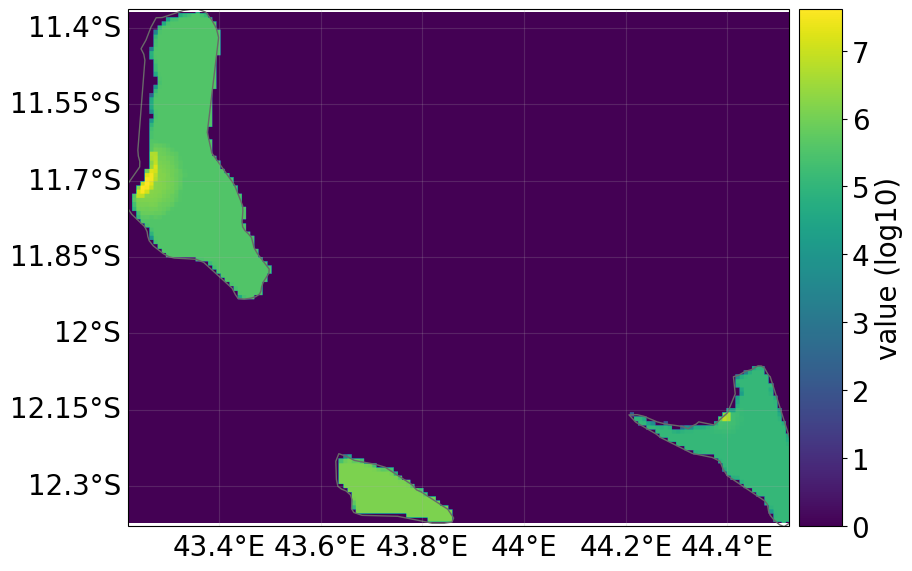

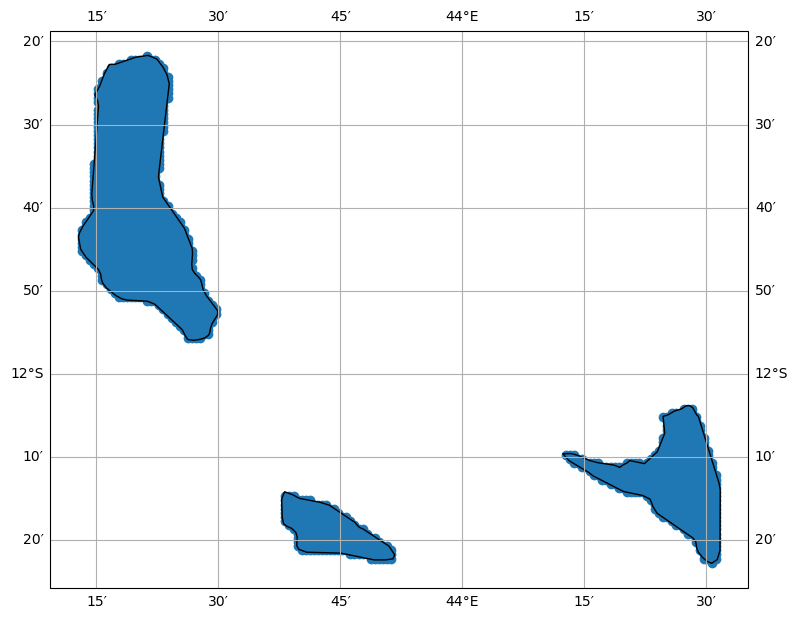

In [62]:
#Generate exposure data, centroids, and identify applicable basin, and filter accordingly tc tracks
country = 174

exp, centrs, applicable_basins, storm_basin_sub, tc_storms = ex.init_TC_exp(storms_basin, country, load_fls=False)

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\grider.py:100: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  


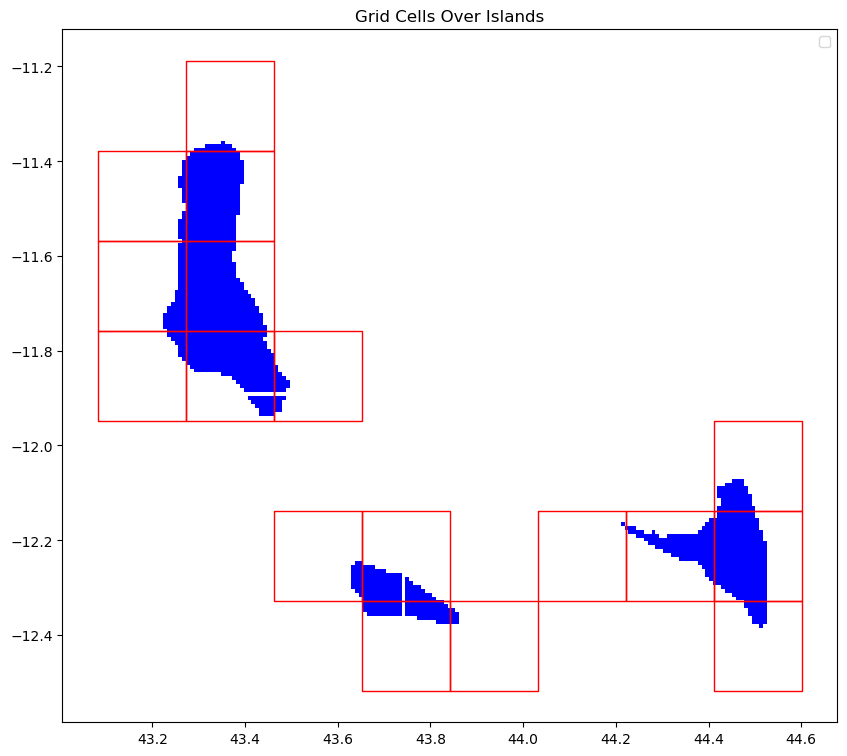

In [63]:
rst_grid = grd.init_grid(exp)

In [ ]:
#plot filtered tc hazards
ax_sub = storm_basin_sub.plot()
ax_sub.get_legend()._loc = 3

### Calculate Impact

In [64]:
#import regional calibrated impact function for TC
# prepare impact calcuation - after Samuel Eberenz
# The iso3n codes need to be consistent with the column “region_id” in the 
# 1. Init impact functions:
impact_func_set = trop_cyclone.ImpfSetTropCyclone()
impf_set = impact_func_set.from_calibrated_regional_ImpfSet()
impf_set.check()

# get mapping: country ISO3n per region:
iso3n_per_region = impf_id_per_region = impact_func_set.get_countries_per_region()[2]
    
code_regions = {'NA1': 1, 'NA2': 2, 'NI': 3, 'OC': 4, 'SI': 5, 'WP1': 6, \
                'WP2': 7, 'WP3': 8, 'WP4': 9, 'ROW': 10}

# match exposure with correspoding impact function
for calibration_region in impf_id_per_region:
    for country_iso3n in iso3n_per_region[calibration_region]:
        exp.gdf.loc[exp.gdf.region_id== country_iso3n, 'impf_TC'] = code_regions[calibration_region]

imp = ImpactCalc(exp, impf_set, tc_storms).impact(save_mat=True)

1225039196.61091


<Axes: title={'center': 'TC 5: South Indian (SI)'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

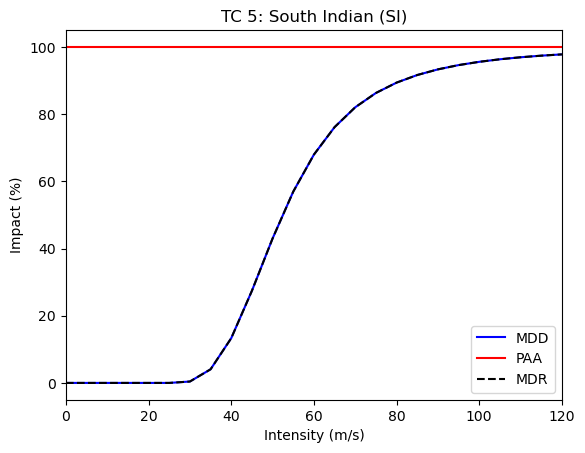

In [80]:
impf_set.plot(fun_id=5)

68710664.87475216
2594192.7886363133


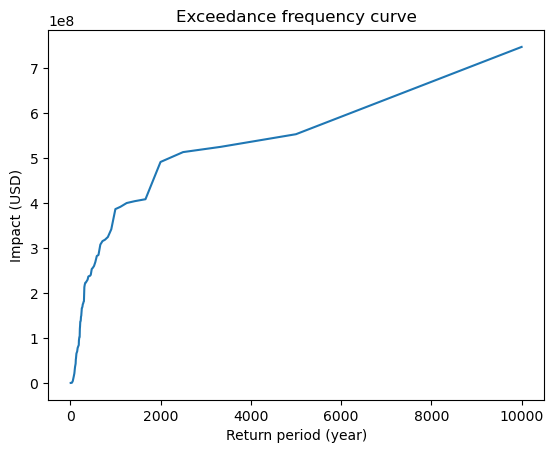

In [71]:
#compute exceedance frequency curve
frequ_curve = imp.calc_freq_curve()
frequ_curve.plot()
imp_per_exp = imp.imp_mat

In [83]:
#define nominal, minimum payout, and affected percentage of gdp for the 150 year event
tot_exp = exp.gdf['value'].sum()
nominal = imp.calc_freq_curve(return_per=150).impact
min_pay = imp.calc_freq_curve(return_per=50).impact
max_rel_imp = nominal/tot_exp

In [97]:
#define payout functions
x = 40
y = 70
m = (nominal - min_pay) / (y - x)
b = nominal - (m * y)
wind_speed = 50


if x <= wind_speed <= y:
    payout = m * wind_speed + b
elif wind_speed > y:
    payout = nominal
else:
    payout = 0

print(payout)


24633016.81734161


In [72]:
print(imp_per_exp)
print(imp_per_exp[0,1])

  (0, 1)	12.192699529669579
  (0, 2)	193.12039757482952
  (0, 3)	1098.4301004972658
  (0, 4)	3162.8859178872976
  (0, 5)	4423.914007874254
  (0, 6)	2127.0701021350105
  (0, 7)	2220.3827780331044
  (0, 8)	720.7651270543462
  (0, 10)	5828.043098640191
  (0, 11)	5150.933470747733
  (0, 12)	4979.862204112118
  (0, 13)	4807.806541803036
  (0, 14)	4634.960307084478
  (0, 15)	4450.250087789967
  (0, 16)	3598.9849251332635
  (0, 17)	2897.9479950041246
  (0, 18)	673.0222774127543
  (0, 21)	7078.122414408403
  (0, 22)	5568.989828643182
  (0, 23)	5117.333806893432
  (0, 24)	4942.631266083335
  (0, 25)	4767.1481259971715
  (0, 26)	4591.068816933415
  (0, 27)	4414.561732721851
  (0, 28)	4237.784575457418
  :	:
  (1003, 1984)	618.7255968913381
  (1003, 1985)	609.951628625536
  (1003, 1986)	600.896396903728
  (1003, 1987)	65.72910728725488
  (1003, 1988)	476.27315545335296
  (1003, 1989)	665.070128653411
  (1003, 1990)	657.0110107631491
  (1006, 749)	1.303787055863064
  (1006, 750)	3.3814291117019746

In [73]:
# Perform a spatial join to associate each point with a grid cell
exp_to_grid = exp.gdf.sjoin(rst_grid,how='left', predicate="within")

In [74]:
agg_exp = exp_to_grid.groupby('grid_letter').apply(lambda x: x.index.tolist())

# Dictionary to store the selected values for each letter
imp_grid_evt = {}

# Loop through each letter and its corresponding line numbers
for letter, line_numbers in agg_exp.items():
    # Select all rows for the specified columns in the CRS matrix
    selected_values = imp_per_exp[:, line_numbers]
    
    # Store the selected values in the dictionary
    imp_grid_evt[letter] = selected_values

